In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
class RBM(object):
    '''
    This is a class to analysis statistic mechanics of RBM.
    '''
    def __init__(self,N, M):
        '''
        To get a realization of class, number of visible node (N) and number of hidden node (M) are required.
        n_v: number of visible node, 
        n_h: number of hidden node, 
        weights: weights, 
        phi: bias of visible layer,
        h: bias of hidden layer. 
         '''
        self.n_v = N
        self.n_h = M
        self.weights = np.random.randn(N,M)/N
        self.phi = np.random.randn(1,N)/N
        self.h = np.random.randn(1,M)/M
    
    def exact_F(self):
        '''
        Calculating the exact free energy by enumeration.
        free energy and magnetization are returned.
        '''
        if self.n_v > 20:
            print('N is too large to compute the exact free energy.')
            return np.nan
        Z = 0
        m_i = 0 
        for i in range(2**(self.n_v)):
            x = i*1
            sigma = self.generate_configuration(x,self.n_v)
            temp = np.exp( (self.phi*sigma).sum() + np.log( 2* np.cosh ( sigma.dot(self.weights) + self.h ) ).sum()  - 10)
            Z = Z + temp
            m_i = m_i + sigma*temp
        return -1*np.log(Z) - 10, m_i/Z
    
    def generate_configuration(self,n,N):
        '''
        Generating the nth configuration of visible layer to calculate exact free energy.
        Configuration is returned.
        '''
        x = n*1
        sigma = []
        for i in range(N):
            sigma.append(float(int(x/(2**(N-i-1)))))
            x = x-sigma[-1]*(2**(N-i-1))
        return 2*np.asarray(sigma)-1
    
    def BA_F(self):
        '''
        Calculating the free energy and thermal average by Bethe approximation.
        Free energy, cavity magnetization, thermal average terms are returned.
        '''
        m = np.random.rand(self.n_v, self.n_h)
        for j in range(1000): 
            temp = m*1
            G = ((self.weights*m).sum(0).reshape(1,-1)-self.weights*m).T
            u = 1/2*np.log( np.cosh(self.h.T + G + self.weights.T)/np.cosh(self.h.T + G - self.weights.T) )
            m = np.tanh(self.phi.T + (u.sum(0).reshape(1,-1) - u).T)
            if np.abs(m-temp).sum()<1e-5:
                #print('convergeddd',end=';')
                break
        xi = ((self.weights**2*(1-m**2)).sum(0).reshape(1,-1) - self.weights**2*(1-m**2)).T 
        F_i = self.phi + (xi/2 +  np.log(2*np.cosh(G+self.h.T+self.weights.T))).sum(0) + np.log(1+np.exp(-2*u.sum(0) - 2*self.phi))
        G = (self.weights*m).sum(0).reshape(1,self.n_h)
        xi = (self.weights**2*(1-m**2)).sum(0).reshape(1,-1)
        F_a = (xi/2)+np.log(2*np.cosh(self.h+G))  
        m_i = np.tanh(self.phi + u.sum(0).reshape(1,-1))
        tile_xi = ((1-m_i**2).dot(self.weights**2)).reshape(1,self.n_h)
        tile_G = self.h + m_i.dot(self.weights).reshape(1,self.n_h)
        rn = np.random.randn(500,self.n_h)
        m_a = np.tanh(np.sqrt(tile_xi)*rn + tile_G).mean(0).reshape(1,self.n_h)
        A = (np.tanh(np.sqrt(tile_xi)*rn + tile_G)**2).mean(0).reshape(1,self.n_h)
        C = m_a.T.dot(m_i) + self.weights.T*A.T.dot((1-m_i**2))
        return -1*F_i.sum() + (self.n_v-1)*F_a.sum(), m, [m_i, m_a, C]
        
    
    
    def variance(self,m):
        '''
        Calculating variance of the network.
        Cavity magnetization is required.
        S(t'+1)/S(t'), and list of S(t)/S(0) are returned
        '''
        G = ((self.weights*m).sum(0).reshape(1,-1)-self.weights*m).T
        v = m**2
        s0 = v.sum()
        Gamma = self.h.T + G + self.weights.T
        x = ( np.tanh(Gamma) - np.tanh(Gamma - 2*self.weights.T) )**2
        alpha = 1
        st_s0 = [1]
        for i in range(500):
            temp_v = v*1
            p = (((self.weights**2)*v).sum(0).reshape(1,-1) - (self.weights**2)*v).T
            temp = p*x
            v = (((1-m**2)**2) *(temp.sum(0) - temp).T/4 )
            if i < 25:
                st_s0.append(v.sum()/s0)
            if np.abs(v-temp_v).sum()<1e-5:
                #print('converged')
                break   
        temp_v = v*1
        p = (((w**2)*v).sum(0).reshape(1,-1) - w**2*v).T
        temp = p*x
        v =  (((1-m**2)**2) *(temp.sum(0).reshape(1,-1) - temp).T / 4 )
        return v.sum()/temp_v.sum(), st_s0

In [3]:
np.random.seed(1)

# Free energy density calculation

## Free energy density vs alpha

In [4]:
f_alpha_10 = []
N = 1000
M = 500
g = 1
v = 0.05
rbm = RBM(1000,500)
for i in range(10):
    f=[]
    for j in range(8):
        alpha = (j+1)/10
        M = int(alpha*N)
        w = np.random.randn(N,M)*np.sqrt(g/N)
        h = np.random.randn(1,M)*np.sqrt(v)
        phi = np.random.randn(1,N)*np.sqrt(v)
        rbm.n_v = N
        rbm.n_h = M
        rbm.weights = w
        rbm.h = h
        rbm.phi = phi
        F = rbm.BA_F()[0]
        f.append(F/N)
    f_alpha_10.append(f)

## Free energy density vs g

In [5]:
f_g_10 = []
N = 1000
v = 0.05
for i in range(10):
    f=[]
    for j in range(12):
        alpha = 0.5
        M = int(alpha*N)
        g = (j+1)/10
        w = np.random.randn(N,M)*np.sqrt(g/N)
        h = np.random.randn(1,M)*np.sqrt(v)
        phi = np.random.randn(1,N)*np.sqrt(v)
        rbm.n_v = N
        rbm.n_h = M
        rbm.weights = w
        rbm.h = h
        rbm.phi = phi
        F = rbm.BA_F()[0]
        f.append(F/N)
    f_g_10.append(f)

## Free energy density vs v

In [6]:
f_v_10 = []
N = 1000
g = 1
alpha = 0.5
M = int(alpha*N)
for i in range(10):
    f=[]
    for j in range(6):
        v = (j+1)/100
        w = np.random.randn(N,M)*np.sqrt(g/N)
        h = np.random.randn(1,M)*np.sqrt(v)
        phi = np.random.randn(1,N)*np.sqrt(v)
        rbm.n_v = N
        rbm.n_h = M
        rbm.weights = w
        rbm.h = h
        rbm.phi = phi
        F = rbm.BA_F()[0]
        f.append(F/N)
    f_v_10.append(f)

## BA free energy density vs exact free energy density

In [7]:
f_exact_10 = []
f_BA_10 = []
N = 20
alpha = 0.6
g = 1
v = 0.05
M = int(alpha*N)
rbm.n_v = N
rbm.n_h = M
for i in range(8):
    print(i)
    w = []
    phi = []
    h = []
    for j in range(10):
        alpha = 0.1+i/10
        M = int(alpha*N)
        w.append(np.random.randn(N,M)*np.sqrt(g/N))
        h.append(np.random.randn(1,M)*np.sqrt(v))
        phi.append(np.random.randn(1,N)*np.sqrt(v))
    f_BA = []
    f_exact = []
    for j in range(len(w)):
        rbm.n_h = M
        rbm.weights = w[j]
        rbm.h = h[j]
        rbm.phi = phi[j]
        f_exact.append(rbm.exact_F()[0])
        f_BA.append(rbm.BA_F()[0])
    f_BA_10.append(f_BA)
    f_exact_10.append(f_exact)

0
1
2
3
4
5
6
7


## Drawing the free energy density calculation results
These results correspond to fig.2 in the results of the origin paper. 

(array([-1.49, -1.48, -1.47, -1.46, -1.45, -1.44, -1.43, -1.42, -1.41,
        -1.4 , -1.39]), <a list of 11 Text xticklabel objects>)

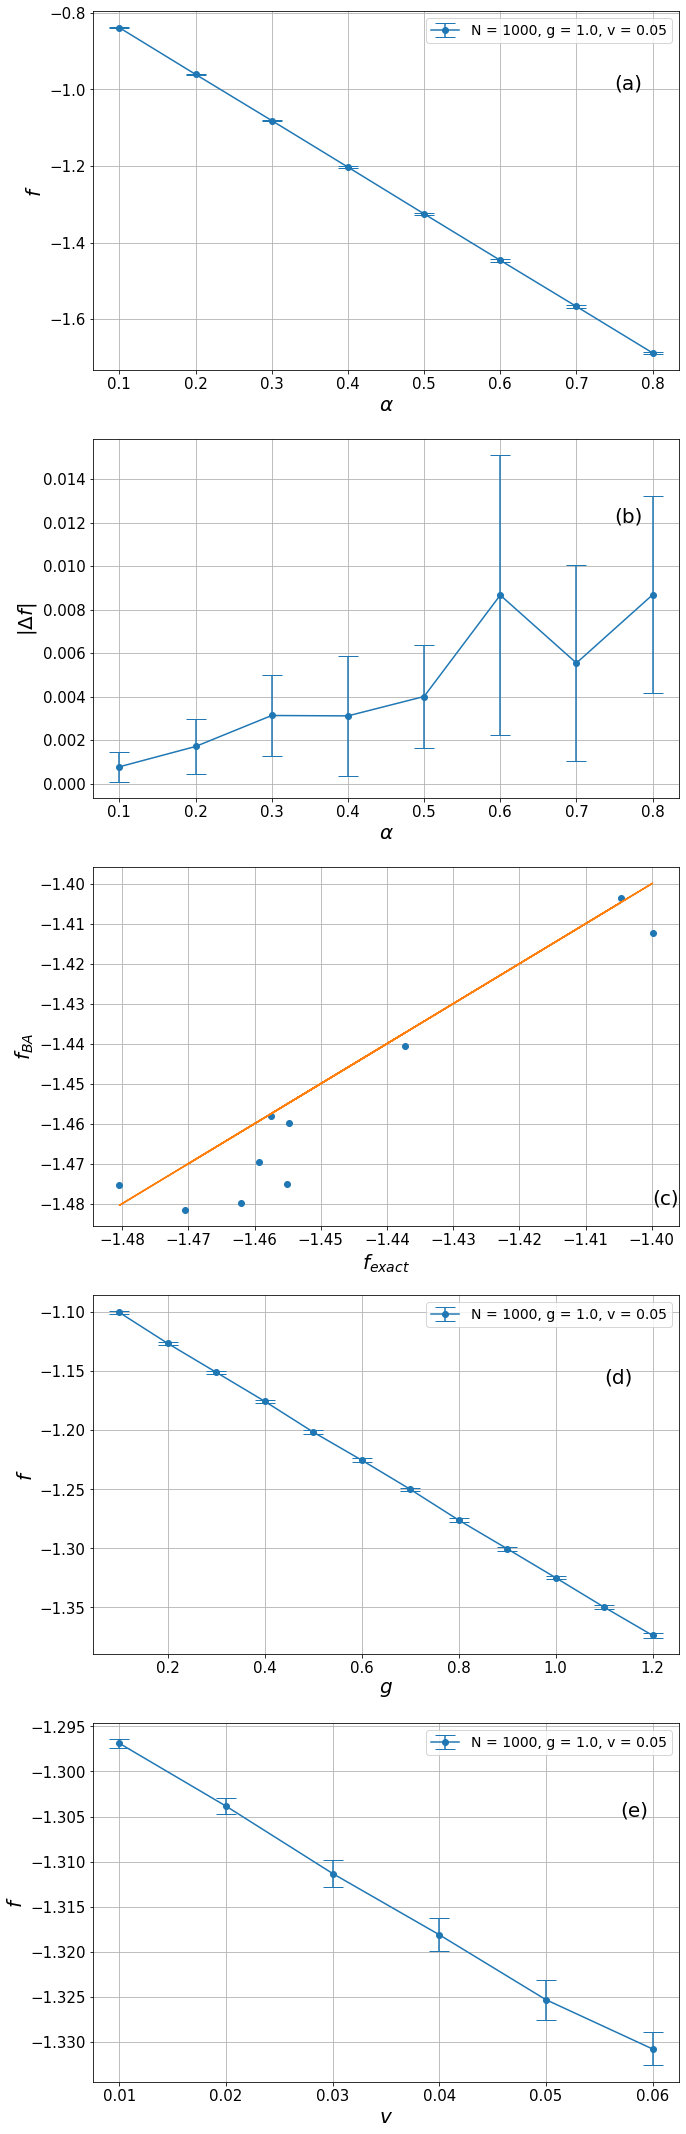

In [8]:
A = plt.figure(figsize=(10,30))
plt.subplot(5,1,1)
plt.grid()
plt.tight_layout(pad = 2)
f_10 = np.asarray(f_alpha_10)
plt.errorbar([(i+1)/10 for i in range(8)],f_10.mean(0),f_10.std(0),fmt = '-o',capsize = 10,label = 'N = 1000, g = 1.0, v = 0.05')
plt.xlabel(r'$\alpha$',fontsize = 20)
plt.ylabel(r'$f$',fontsize = 20)
plt.legend(fontsize = 14)
plt.text(0.75,-1, '(a)',fontsize = 20)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.subplot(5,1,4)
plt.grid()
plt.tight_layout(pad = 2)
f_10 = np.asarray(f_g_10)
plt.errorbar([(i+1)/10 for i in range(f_10.shape[1])],f_10.mean(0),f_10.std(0),fmt = '-o',capsize = 10,label ='N = 1000, g = 1.0, v = 0.05')
plt.xlabel(r'$g$',fontsize = 20)
plt.ylabel(r'$f$',fontsize = 20)
plt.legend(fontsize = 14)
plt.text(1.1,-1.16, '(d)',fontsize = 20)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.subplot(5,1,5)
plt.grid()
plt.tight_layout(pad = 2)
f_10 = np.asarray(f_v_10)
plt.errorbar([(i+1)/100 for i in range(f_10.shape[1])],f_10.mean(0),f_10.std(0),fmt = '-o',capsize = 10, label = 'N = 1000, g = 1.0, v = 0.05')
plt.xlabel(r'$v$',fontsize = 20)
plt.ylabel(r'$f$',fontsize = 20)
plt.legend(fontsize = 14)
plt.text(0.057,-1.305, '(e)',fontsize = 20)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

f1 = np.asarray(f_exact_10)
f2 = np.asarray(f_BA_10)
ab = np.abs(f1-f2)/20

plt.subplot(5,1,2)
plt.grid()
plt.tight_layout(pad = 2)
plt.errorbar([0.1+j/10 for j in range(8)], ab.mean(1),ab.std(1),fmt='-o',capsize = 10)
plt.text(0.75,0.012, '(b)',fontsize = 20)
plt.xlabel(r'$\alpha$',fontsize = 20)
plt.ylabel(r'|$\Delta f$|',fontsize = 20)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.subplot(5,1,3)
plt.grid()
plt.tight_layout(pad = 2)
plt.text(-1.40,-1.48, '(c)',fontsize = 20)
plt.plot(f1[5,:]/20,f2[5,:]/20,'o')
plt.plot(f1[5,:]/20,f1[5,:]/20)
plt.xlabel(r'$f_{exact}$',fontsize = 20)
plt.ylabel(r'$f_{BA}$',fontsize = 20)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

## $\lambda$ vs g

In [9]:
ld_g_10 = []
for k in range(21):
    ld = []
    for i in range(20):
        N = 1000
        alpha = 0.5
        v = 0.05
        g= 0.1+0.1*k
        M = int(alpha*N)
        w = np.random.randn(N,M)*np.sqrt(g/N)
        h = np.random.randn(1,M)*np.sqrt(v)
        phi = np.random.randn(1,N)*np.sqrt(v)
        rbm.n_v = N
        rbm.n_h = M
        rbm.weights = w
        rbm.h = h
        rbm.phi = phi
        m = rbm.BA_F()[1]
        ld.append(rbm.variance(m)[0])
    ld_g_10.append(ld)

## $\lambda$ vs $\alpha$

In [10]:
N = 1000
alpha = 0.5
v = 0.05
M = int(alpha*N)
g = 1
ld_alpha_10 = []
for i in range(5):
    ld = []
    for j in range(20):
        alpha = 0.8 + i/5
        M = int(alpha*N)
        w = np.random.randn(N,M)*np.sqrt(g/N)
        h = np.random.randn(1,M)*np.sqrt(v)
        phi = np.random.randn(1,N)*np.sqrt(v)
        rbm.n_v = N
        rbm.n_h = M
        rbm.weights = w
        rbm.h = h
        rbm.phi = phi
        m = rbm.BA_F()[1]
        ld.append(rbm.variance(m)[0])
    ld_alpha_10.append(ld)

## Drawing stability analysis calculation results
These results correspond to fig.3 in the results of the origin paper.

(array([0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7]),
 <a list of 11 Text xticklabel objects>)

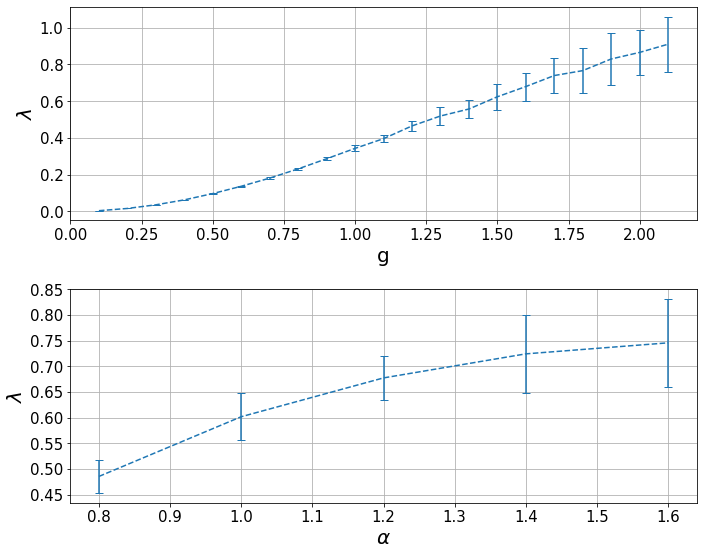

In [12]:
A = plt.figure(figsize = (10,8))
plt.subplot(2,1,1)
ld = np.asarray(ld_g_10)*1
plt.errorbar([0.1 + i/10 for i in range(ld.shape[0])], ld.mean(1), ld.std(1),fmt = '--',capsize = 4)
plt.xlabel(r'g',fontsize=20)
plt.ylabel(r'$\lambda$', fontsize = 20) 
plt.grid()
plt.tight_layout(pad = 2)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

plt.subplot(2,1,2)
ld = np.asarray(ld_alpha_10)*1
plt.errorbar([0.8 + i/5 for i in range(ld.shape[0])], ld.mean(1), ld.std(1),fmt = '--',capsize = 4)
plt.xlabel(r'$\alpha$',fontsize=20)
plt.ylabel(r'$\lambda$', fontsize = 20) 
plt.grid()
plt.tight_layout(pad = 2)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)

# Conclusion
Compared to the origin results of paper, these results basically match to them. But some experiments here have large statistical error compare. The possible reason may be the random numbers are not perfect Gaussian distribution. This remains a problem. 